# Fit Demo -- Simulated AGN
---------------------------
Simulate data with the AGN module included, fit it, and see how close to the input parameters we
get.

## Imports

In [1]:
import h5py
import numpy as np
import astropy.units as u
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Initialize Lightning

In [3]:
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                 'MIPS_CH1',
                 'PACS_green', 'PACS_red']

# Redshift 0, default stellar age bins
lgh = Lightning(filter_labels, 
                lum_dist=10.0, # Mpc
                SFH_type='Piecewise-Constant',
                atten_type='Modified-Calzetti',
                dust_emission=True,
                agn_emission=True,
                print_setup_time=True)

0.015 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.691 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.221 s elapsed in dust emission model setup
0.032 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
0.960 s elapsed total


In [4]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- --- --------------------------------------------------------
mcalz_tauV_diff  0.0 inf                         Optical depth of the diffuse ISM
    mcalz_delta -inf inf      Deviation from the Calzetti+2000 UV power law slope
  mcalz_tauV_BC  0.0 inf Optical depth of the birth cloud in star forming regions

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0

## Fake some data

In [5]:
params = np.array([1,1,1,1,1,
                   0.3, 0.0, 0.0,
                   2, 1, 3e5, 0.1, 0.01,
                   11, 0.5, 7, 0.1])

Lmod, _ = lgh.get_model_lnu(params)

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
DL = 10 * u.Mpc

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
lgh.flux_obs = fsim
lgh.flux_unc = fsim_unc

## Fit with `emcee`

In [13]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01,
              11, 0.5, 7, 0.1])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, True, True,
                      True, False, True, False, False,
                      False, False, True, False])

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          UniformPrior([-3, 3]), # delta
          None, # tauV birth cloud
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # gamma
          UniformPrior([0.0047, 0.0458]), # q_PAH
          UniformPrior([10, 12]), # L_AGN
          UniformPrior([0,1]), # cos i
          None, # tau97
          UniformPrior([0, 1]) # tau PD
         ]

var_dim = ~const_dim

Nwalkers = 64
Nsteps = 20000

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(Nwalkers, len(p)))
p0[:, const_dim] = p[const_dim]

# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = lgh.fit(p0,
               method='emcee',
               Nwalkers=Nwalkers,
               Nsteps=Nsteps,
               const_dim=const_dim,
               priors=priors
               )

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [40:36<00:00,  8.21it/s]


Check on the acceptance fraction and construct the final chain:

In [14]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# The autocorrelation time is <= 500; emcee is gonna tell us that the esimate of the
# autocorrelation time is bad because we haven't run a long enough chain (it's right)
# so the below line is commented out
#print('MCMC mean autocorrelation time: %.1f' % (np.mean(mcmc.get_autocorr_time())))

MCMC mean acceptance fraction: 0.186


In [7]:
# chain = mcmc.get_chain(discard=1000, thin=250, flat=True)[-1000:, :]
# logprob_chain = mcmc.get_log_prob(discard=1000, thin=250, flat=True)[-1000:]

In [24]:
# Extra MCMC steps just in case the below tripped emcee's autocorrelation time
# exception.
state = mcmc.run_mcmc(None, 5000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [25:07<00:00,  3.32it/s]


In [15]:
# Automatically construct chopped/thinned/flattened chains
# based on the autocorrelation times of the chains, and retain the
# last 1000 samples. If we instead got a message
# here that the autocorrelation times were too long, we could:
# - Provide a manual scale for burn-in and thinning since emcee is extremely conservative
#   and won't give us the autocorrelation scale if even one parameter is slightly longer than N/50
# - Re-run the whole MCMC (expensive)
# - Simply continue the MCMC where it left off by doing mcmc.run_mcmc(None, Nsteps).
chain, logprob_chain, tau_ac = l.get_mcmc_chains(mcmc, discard=2000, thin=500,
                                                 const_dim=const_dim,
                                                 const_vals=p[const_dim])

         The autocorrelation estimate may be unreliable.


In [28]:
# Reassembling the parameter array by including the constant parameters
# since the new plot functions want the whole set.
# param_arr = np.zeros((chain.shape[0], l.Nparams))
# param_arr[:, const_dim] = p[None, const_dim]
# param_arr[:, var_dim] = chain

### Chain Plot

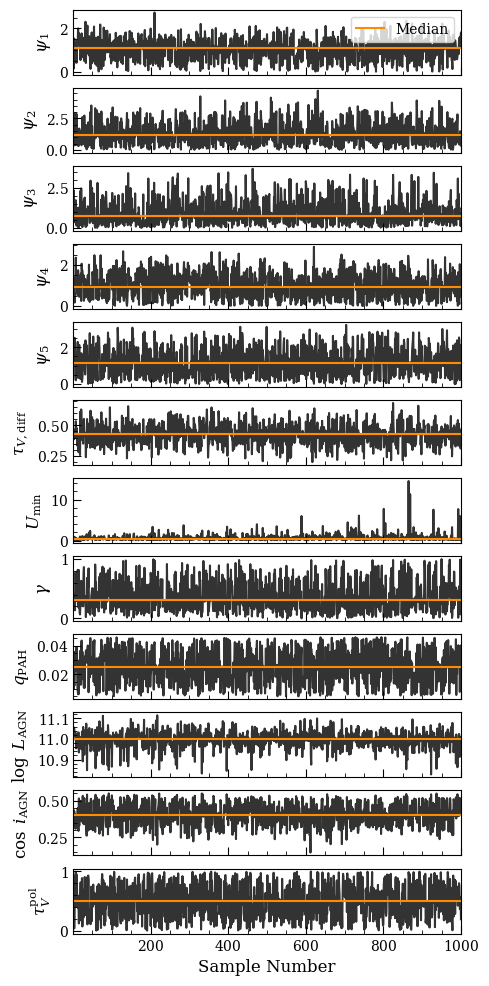

In [16]:
# from lightning.plots import chain_plot

# fig, axs = chain_plot(l, param_arr, color='k', alpha=0.8)
fig, axs = lgh.chain_plot(chain, color='k', alpha=0.8)

### Corner Plot
And now a corner plot for the whole set of parameters:

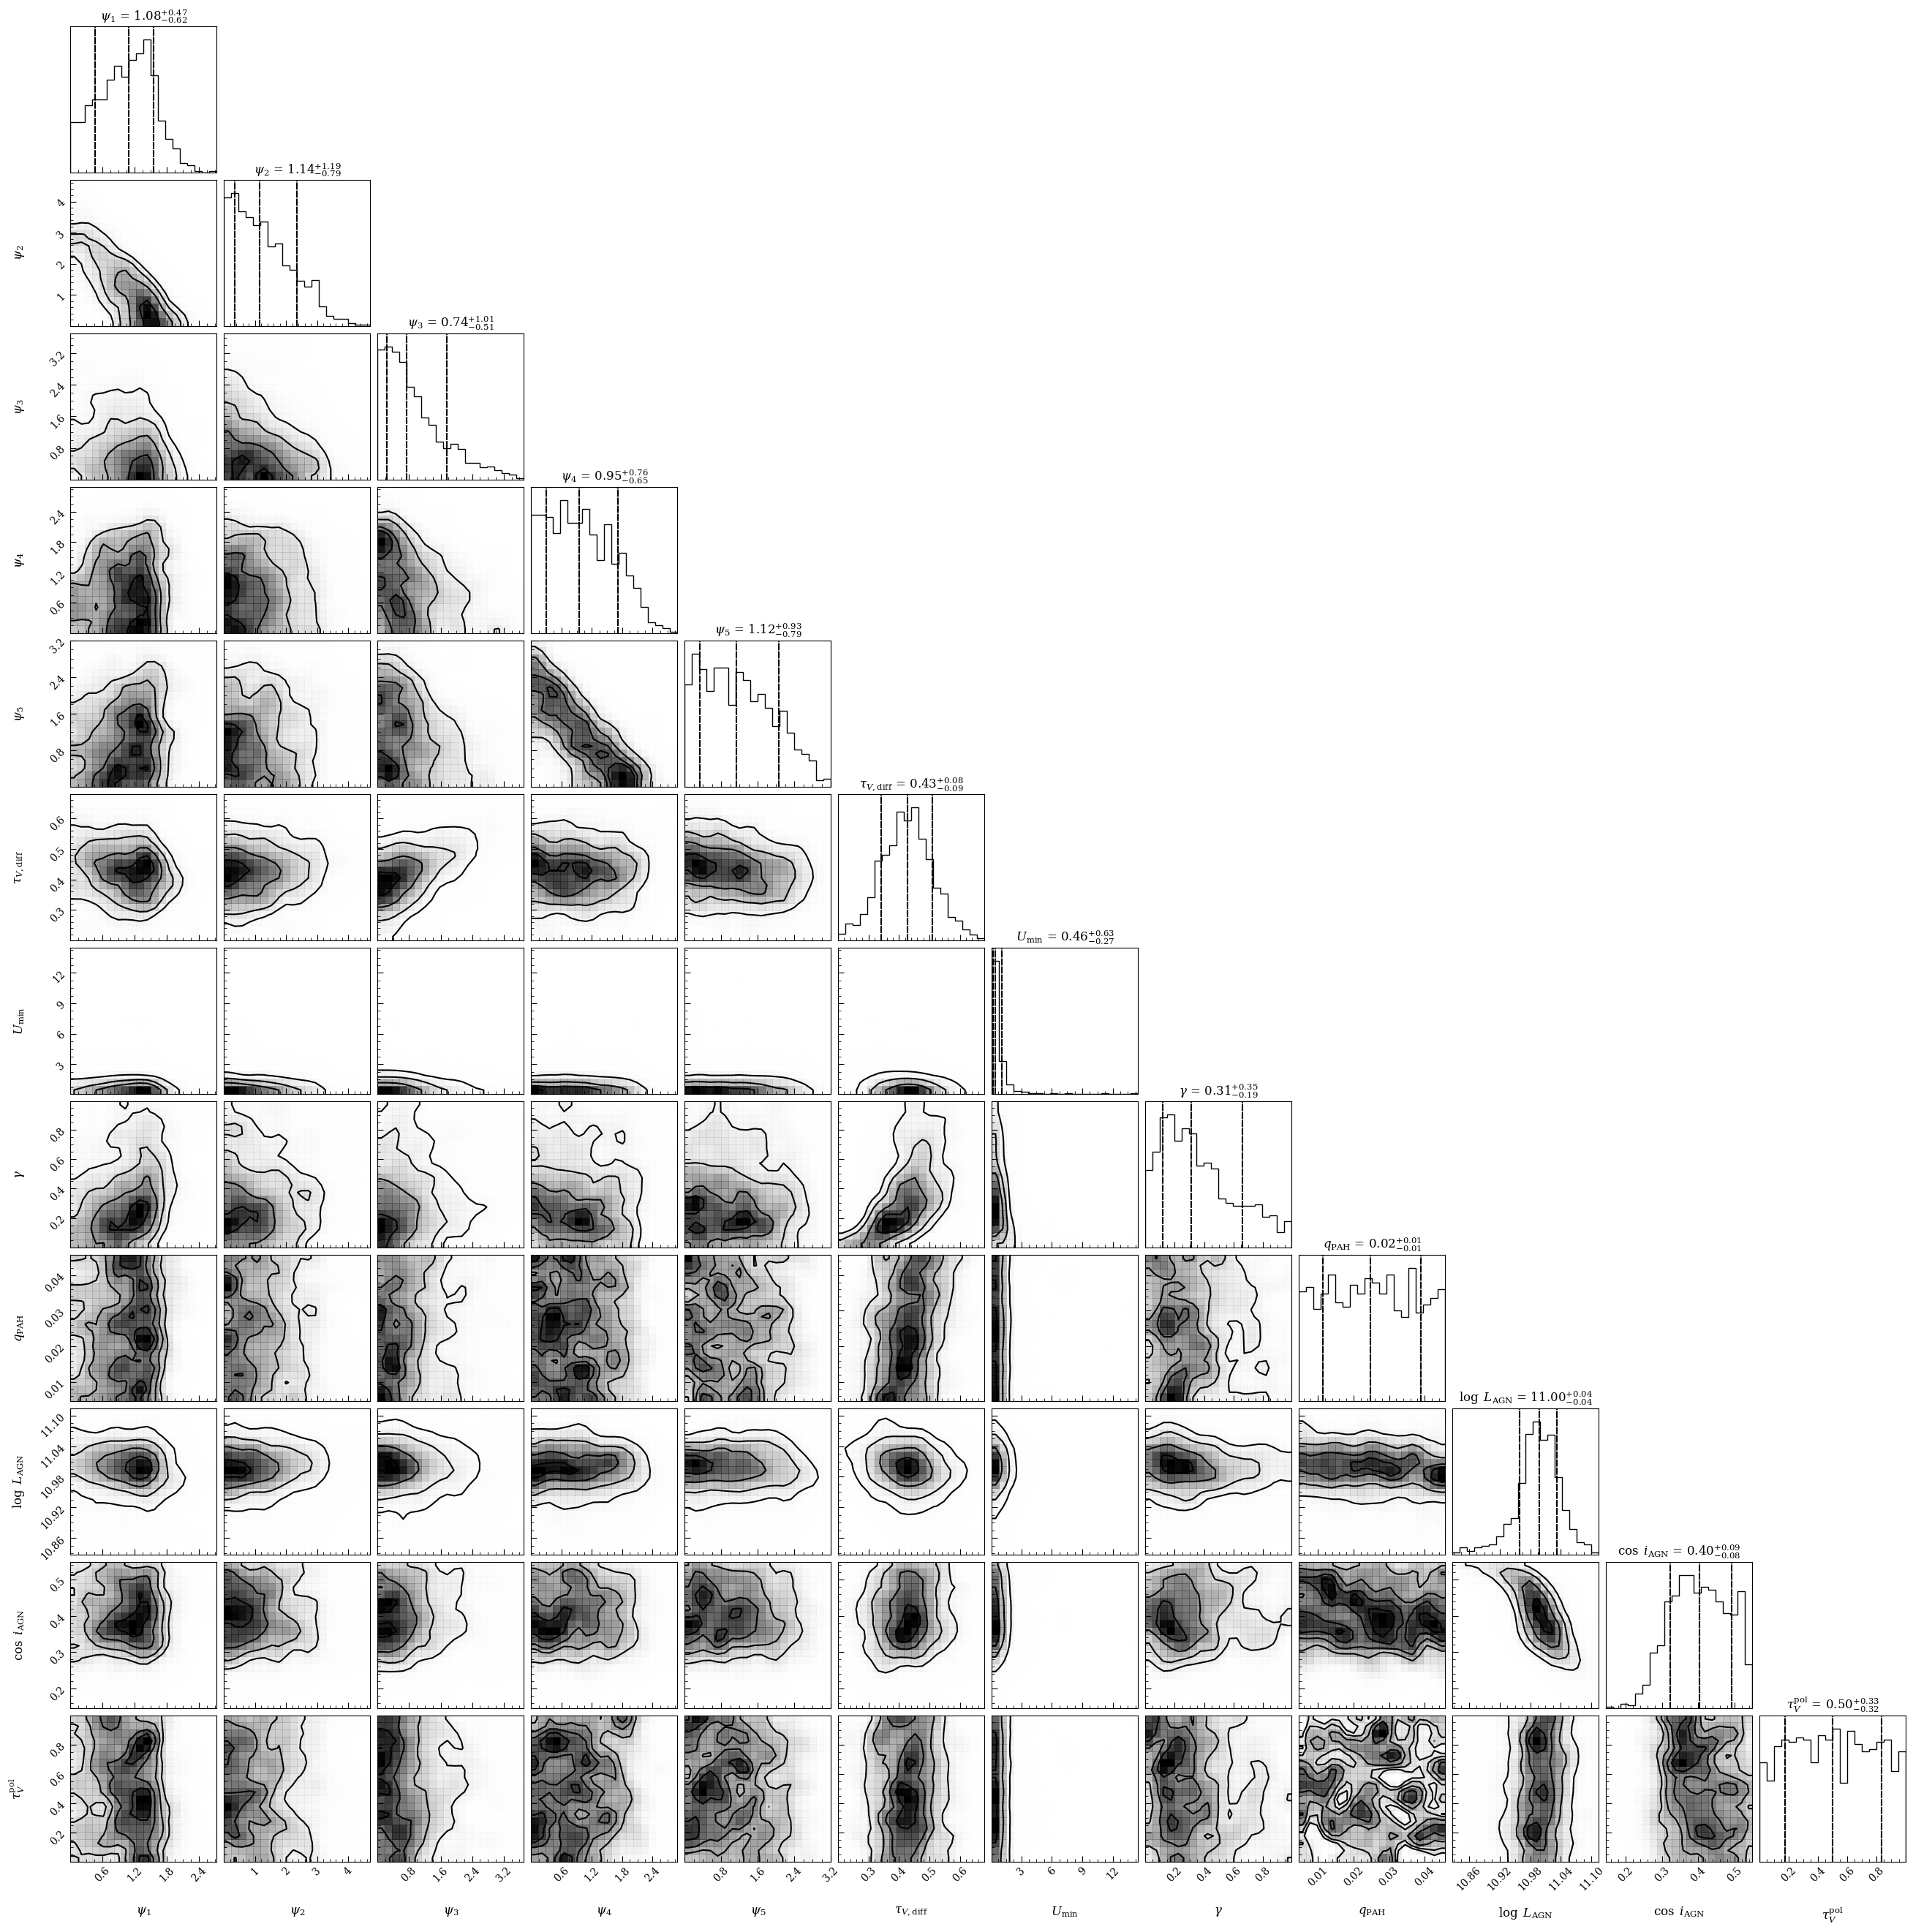

In [18]:
# from lightning.plots import corner_plot

# fig = corner_plot(l, param_arr, 
#                   quantiles=(0.16, 0.50, 0.84),
#                   smooth=1,
#                   levels=None,
#                   show_titles=True)

fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

Sick. We can see pretty obviously that there's no constraint on the polar dust optical depth with these data and choice of viewing angle.

### Best fit SED/Sampled SFH plot
This'll be our typical plot, with the best-fit SED and the 16th-84th percentile of the SFH. In the future this first block would be handled by a helper method of the `Lightning` class that ingests the fitting
result (MCMC sampler from `emcee`, optimization result from `scipy.optimize`, maybe `MultiNest`, who knows).

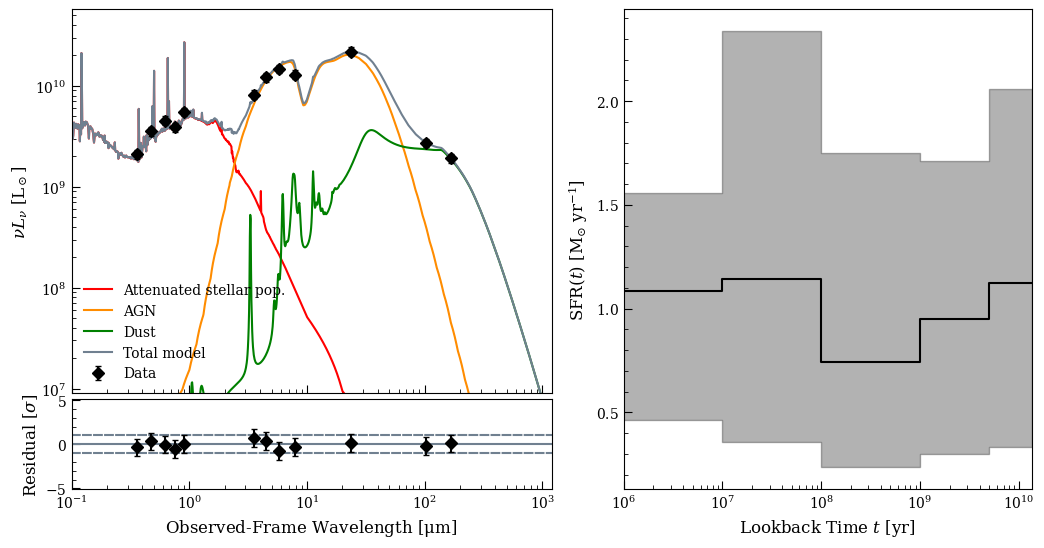

In [19]:
#from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# We can use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex (hopefully) publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

# fig4, ax41 = sed_plot_bestfit(l, param_arr, logprob_chain,
#                               plot_components=True,
#                               ax=ax41,
#                               legend_kwargs={'loc': 'lower left', 'frameon': False})
# ax41.set_xticklabels([])
# fig4, ax42 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax42)
# fig4, ax43 = sfh_plot(l, param_arr, ax=ax43)

fig4, ax41 = lgh.sed_plot_bestfit(chain, logprob_chain,
                              plot_components=True,
                              ax=ax41,
                              legend_kwargs={'loc': 'lower left', 'frameon': False})
ax41.set_xticklabels([])
fig4, ax42 = lgh.sed_plot_delchi(chain, logprob_chain, ax=ax42)
fig4, ax43 = lgh.sfh_plot(chain, ax=ax43)

Radical.